# High Altitude Home Runs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In order to start, we have to define the equation that defines the projectile motion of the ball. In order to do this I will define the forces that act on the ball seperately to simplify the final equation.

According to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balldrag.html) the drag coefficient on a baseball is equal to 0.3
Similarly according to NASA (https://www.grc.nasa.gov/WWW/K-12/airplane/balllift.html) the lift coefficient on a baseball is 0.15

It is also important to note that a baseball's circumfrence and mass are not constant for all baseballs, instead they fall inside a tolerance. The range for circumfrence is .229-.235 meters and the mass is .142-.149 kg (https://en.wikipedia.org/wiki/Baseball_(ball)#:~:targetText=Under%20the%20current%20rules%2C%20a,%E2%80%9376%20mm%20in%20diameter). We will just be using the middle of the range as an approximation; i.e .232 m and .1455 kg

For air density, we will just be using the values provided here (https://www.purplerow.com/2018/1/8/16846116/colorado-rockies-coors-field-arizona-diamondbacks-chase-field-comparison#:~:targetText=On%20a%20typical%20summer%20day,has%20an%20air%20density%20of%20.) This also provides us with an air density for San Diego which we will use as our control.

Average Pitch Height of 1.14 meters

Average Spin based on launch angle (https://fivethirtyeight.com/features/home-runs-are-soaring-could-declining-backspin-be-a-factor/)

3800 rpm for 35-39, 3175 for 30-34, 2560 for 25-29, 1975 for 20-24, 1425, for 15-19. We can convert this to rps for the magnus force by dividing by 60 giving us: 63.3 rps for 35-39, 52.916 rps for 30-34, 42.6 rps for 25-29, 32.9 for 20-24, 23.75 rps for 15-19

In [2]:
#Here we will be defining a bunch of constants used later in case we want to change them.
Cd= 0.3
Cl=0.15
mass= .1455 #kg
Rball = .232/(2*np.pi) #meters
CrossA= np.pi*(Rball**2) #meters **2
g=-9.8 #kgm/s**2
Airdensea= 1.182 #kg/m**3
Airdenco= .966  #kg/m**3

termvsea=(np.sqrt ( (2 * mass * g) / (Cd * Airdensea * CrossA) ))
termvco=(np.sqrt ( (2 * mass * g) / (Cd * Airdenco * CrossA) ))



In [3]:
def terminaldrag(Location): #Arg requires either co or sea for the two heights, This terminal drag is never used as the ball never reaches terminal velocity
    if Location == "co":
        return(.5*Cd*Airdenco*CrossA*termvco**2)
    elif Location == "sea":
        return(.5*Cd*Airdensea*CrossA*termvsea**2)

def drag(vel,Location): #This is a function for drag based on the velocity
    if Location == "co":
        return (.5*Cd*Airdenco*CrossA*(vel**2))
    elif Location == "sea":
        return (.5*Cd*Airdensea*CrossA*(vel**2))
    
def lift(vel,spin,Location): #This calculates lift based on spin in rps and the velocity
    if Location == 'co':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdenco * vel) * (4/3))
    elif Location == 'sea':
        return(Cl*(4 * np.pi**2 * Rball**3 * spin * Airdensea * vel) * (4/3))


def ascensionf(vel, Location): #This calculates the total opposing force as the ball rises when drag and gravity are both negative
    if Location == 'co':
        return( (mass*g) - drag(vel, Location))
    elif Location =="sea":
        return( (mass*g) - drag(vel, Location))
    

In [4]:
def Baseballflight(t, y, spin, Location): # This will be the equation solved by the runga kutta method. It includes both the affect on the x and y axis
    '''y is an array with [X0,Y0,Vx,Vy]'''
    
    dydt= np.zeros(4)
    
    dydt[1]=y[3]
    if y[3]>=0:
        dydt[3]= (ascensionf(y[3],Location)+lift(y[2],spin,Location))/mass #it is important to note that as the baseball begins to fall, drag will actually start to help it stay in the air, and thus we must hvave two differnt equations
    elif y[3]<0:
        dydt[3]= ((mass*g)+drag(y[3],Location)+lift(y[2],spin,Location))/mass
    dydt[0]=y[2]
    dydt[2]= ((-lift(y[3],spin,Location)-drag(y[2],Location))/mass)
    return(dydt)

Now I will be including the Runga Kutta method as a way to solve these equations. I will be largely using the code Professor Miller Provided in his example on the Runga Kutta Method. However, I have changed it to work with the function I defined for the flight of the ball. Also I edited to stop if it detected that the ball had hit the ground

In [5]:
def RungeKutta4(func, y_0, t, spin, Location):
    """ Classical Runge-Kutta (RK4) approximation to a first-order ODE system
    with initial conditions.

    Args:
        func: (callable) The first-order ODE system to be approximated.
        y_0:  (array)    The initial condition.
        t:    (array)    A sequence of time points for which to solve for y.
        args: (dict)     Extra arguments to pass to function.

    Out:
        y:    (array)    The approximated solution of the system at each time in t,
                         with the initial value y_0 in the first row.
    """

    # Initialise the approximation array
    y = np.zeros([len(t), len(y_0)])
    y[0] = y_0

    # Loop through the time steps, approximating this step from the prev step
    for i, t_i in enumerate(t[:-1]):
        if y[i][1]<=0:
            return(y)
        else:
            h   = t[i+1] - t_i # size of the step

            k_1 = h*func(t_i, y[i], spin, Location)
            k_2 = h*func(t_i + h/2. , y[i] + k_1/2., spin, Location)
            k_3 = h*func(t_i + h/2. , y[i] + k_2/2., spin, Location)
            k_4 = h*func(t_i + h    , y[i] + k_3, spin, Location)

            y[i+1] = y[i] + 1/6.*(k_1 + 2.*k_2 + 2.*k_3 + k_4) # RK4 step
        
    return y

In [6]:
N     = 250 # Num of steps to take
t_max = 7.5 # Limit of the range to evaluate the function
T    = np.linspace(0., t_max, N+1) # Array of discretized steps

#This is a trial run using the longest home run of the 2019 season
y_0= np.array([0,1.14,48.7*np.cos(27*np.pi/180),48.7*np.sin(27*np.pi/180)])
ysea= RungeKutta4(Baseballflight,y_0,T,42,'sea')
yco=RungeKutta4(Baseballflight,y_0,T,42,'co')

In [7]:
def Cleanerfunc(array): #This function just removes the left over zeroes at the end of the array for cleaner graphs
    temp=array.tolist()
    counter=0
    for k in temp:
        if k[2]==0:
            counter+=1
    for l in range(counter):
        temp.remove([0.0,0.0,0.0,0.0])
    final=np.asarray(temp)       
    return(final)

In [8]:
Seaclean=Cleanerfunc(ysea)

Coclean=Cleanerfunc(yco)

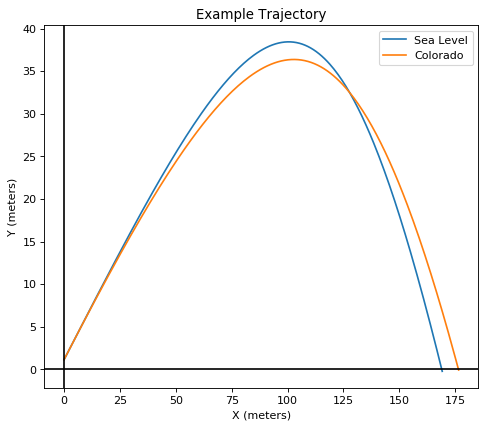

In [9]:
plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Seaclean[:,0],Seaclean[:,1],label='Sea Level')
plt.plot(Coclean[:,0],Coclean[:,1],label='Colorado')


plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title("Example Trajectory")

plt.axhline(color="black")
plt.axvline(color="black")

plt.legend()
plt.savefig('Example Trajectory')

In [10]:
def vacuumbaseball(t,y,spin,location):
        
    dydt= np.zeros(4)
    
    dydt[1]=y[3]
    dydt[3]= g
    dydt[0]=y[2]
    dydt[2]= 0
    return(dydt)
    

In [11]:
Vacuum=RungeKutta4(vacuumbaseball,y_0,T,1,'Sea')
Vacuumclean=Cleanerfunc(Vacuum)
print(Seaclean[-1][0],Coclean[-1][0],Vacuumclean[-1][0])

169.2051486559922 176.54143088150946 199.16936137139845


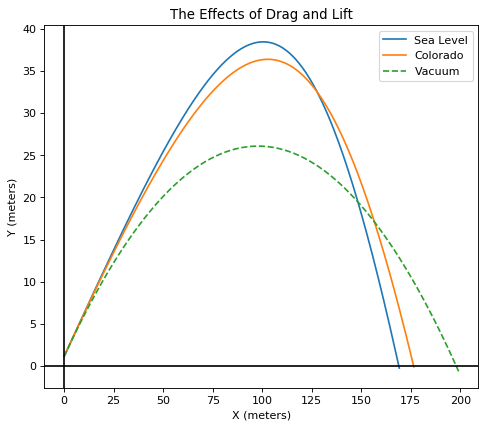

In [12]:
plt.figure(num=None, figsize=(7,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Seaclean[:,0],Seaclean[:,1],label='Sea Level')
plt.plot(Coclean[:,0],Coclean[:,1],label='Colorado')
plt.plot(Vacuumclean[:,0],Vacuumclean[:,1],label="Vacuum",linestyle='--')

plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.title('The Effects of Drag and Lift')

plt.axhline(color="black")
plt.axvline(color="black")

plt.legend()
plt.savefig('Simulation vs Vacuum')

Now we want to test a set of data to see how many more home runs come out of the set than do before. I'll be using hitting data from 3 players, Kris Bryant, Ji-man Choi and Mookie Bets.(https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfBBT=fly%5C.%5C.ball%7C&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfGT=R%7C&hfC=&hfSea=2019%7C&hfSit=&player_type=batter&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfInfield=&team=&position=&hfOutfield=&hfRO=&home_road=&batters_lookup%5B%5D=605141&batters_lookup%5B%5D=592178&batters_lookup%5B%5D=596847&hfFlag=&hfPull=&metric_1=&hfInn=&min_pitches=0&min_results=0&group_by=name&sort_col=pitches&player_event_sort=h_launch_speed&sort_order=desc&min_pas=0#results)
Using Statcast to find the exit velocity and launch angle for all of their fly balls from last season. For the spin I will use the ranges included in the 538 article cited at the beginning:  63.3 rps for 35-39, 52.916 rps for 30-34, 42.6 rps for 25-29, 32.9 for 20-24, 23.75 rps for 15-19. I will calculate how far they would have went using my algorithm for sea level and for colorado and see how many of them get converted to homeruns

In [13]:
mbactualdist,mbspeedmph, mbangledeg = np.loadtxt('Betsdata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2))
kbactualdist,kbspeedmph, kbangledeg = np.loadtxt('Bryantdata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2))
jcactualdist,jcspeedmph, jcangledeg = np.loadtxt('Jimandata.csv', unpack=True, skiprows=1,delimiter=',', usecols=(0,1,2))

mbspeed=(mbspeedmph/2.23694) #convert to mps
kbspeed=(kbspeedmph/2.23694)
jcspeed=(jcspeedmph/2.23694)

mbangle=(mbangledeg*(np.pi/180)) #convert to radian
kbangle=(kbangledeg*(np.pi/180))
jcangle=(jcangledeg*(np.pi/180))


In [14]:
mbspin=[]
for i in mbangledeg:
    if  i >35:
        mbspin.append(63.3)
    elif i<=35 and i > 29:
        mbspin.append(52.916)
    elif i <=29 and i>24:
        mbspin.append(42.6)
    elif i<=24 and i>19:
        mbspin.append(32.9)
    elif i<=19:
        mbspin.append(23.75)
kbspin=[]
for i in kbangledeg:
    if  i >35:
        kbspin.append(63.3)
    elif i<=35 and i > 29:
        kbspin.append(52.916)
    elif i <=29 and i>24:
        kbspin.append(42.6)
    elif i<=24 and i>19:
        kbspin.append(32.9)
    elif i<=19:
        kbspin.append(23.75)
jcspin=[]
for i in jcangledeg:
    if  i >35:
        jcspin.append(63.3)
    elif i<=35 and i > 29:
        jcspin.append(52.916)
    elif i <=29 and i>24:
        jcspin.append(42.6)
    elif i<=24 and i>19:
        jcspin.append(32.9)
    elif i<=19:
        jcspin.append(23.75)
        

In [15]:
y_mb=[] #Lets create a list for all the initial values we need
for i in range (len(mbspeed)):
    y_mb.append([0,1.14,mbspeed[i]*np.cos(mbangle[i]),mbspeed[i]*np.sin(mbangle[i])])
y_kb=[]
for i in range (len(kbspeed)):
    y_kb.append([0,1.14,kbspeed[i]*np.cos(kbangle[i]),kbspeed[i]*np.sin(kbangle[i])])
y_jc=[]
for i in range (len(jcspeed)):
    y_jc.append([0,1.14,jcspeed[i]*np.cos(jcangle[i]),jcspeed[i]*np.sin(jcangle[i])])

In [16]:
mbxfinalco=[]
for y,s in zip (y_mb, mbspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'co')
    tempclean=Cleanerfunc(temp)
    mbxfinalco.append(tempclean[-1][0])
mbxfinalsea=[]
for y,s in zip (y_mb, mbspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'sea')
    tempclean=Cleanerfunc(temp)
    mbxfinalsea.append(tempclean[-1][0])
    

In [17]:
kbxfinalco=[]
for y,s in zip (y_kb, kbspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'co')
    tempclean=Cleanerfunc(temp)
    kbxfinalco.append(tempclean[-1][0])
kbxfinalsea=[]
for y,s in zip (y_kb, kbspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'sea')
    tempclean=Cleanerfunc(temp)
    kbxfinalsea.append(tempclean[-1][0])


In [18]:
jcxfinalco=[]
for y,s in zip (y_jc, jcspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'co')
    tempclean=Cleanerfunc(temp)
    jcxfinalco.append(tempclean[-1][0])
jcxfinalsea=[]
for y,s in zip (y_jc, jcspin):
    temp=RungeKutta4(Baseballflight,y,T,s,'sea')
    tempclean=Cleanerfunc(temp)
    jcxfinalsea.append(tempclean[-1][0])

In order to determine if it was a home run I am using the centerfield distance for Coors field

In [22]:
def Homeruncounter(xdist):
    counter=0
    for d in xdist:
        if d>126:
            counter+=1
    return(counter)
HRjcsea=Homeruncounter(jcxfinalsea)
HRjcco=Homeruncounter(jcxfinalsea)

HRkbsea=Homeruncounter(kbxfinalsea)
HRkbco=Homeruncounter(kbxfinalco)

HRmbsea=Homeruncounter(mbxfinalsea)
HRmbco=Homeruncounter(mbxfinalco)


MBratio=HRmbco/HRmbsea
KBratio=HRkbco/HRkbsea
JCratio=HRjcco/HRjcsea

print(MBratio,KBratio,JCratio)

1.1702127659574468 1.2586206896551724 1.0


If I average this, it will compare with the value I plotted at the very beginning.

In [28]:
AverageFactor=(MBratio+KBratio+JCratio)/3
print(AverageFactor)
Names=['Ji-Man Choi','Kris Bryant','Mookie Betts','Average']
Ratios=[JCratio,KBratio,MBratio,AverageFactor]

1.1429444852042063


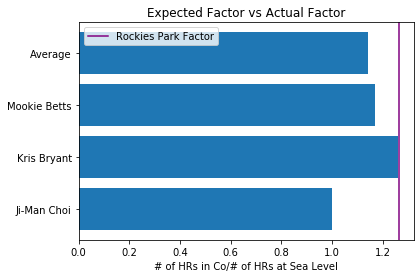

In [29]:
y_pos=np.arange(len(Names))
fig =
plt.barh(y_pos,Ratios,align='center',alpha=1,)
plt.yticks(y_pos,Names)
plt.axvline(x=1.266, color='purple',label= 'Rockies Park Factor')
plt.legend()
plt.xlabel('# of HRs in Co/# of HRs at Sea Level')
plt.title('Expected Factor vs Actual Factor')
plt.savefig('Result')

 There are a few assumptions I made which could have led to error.
    1. I assumed all of the initial velocity goes in the x and y directions and none in the z direction.
    2. Similarly I assumed the ball went straight through centerfield
    3. I also assumed all of the spin was directly backwards
    4. I assumed that there was no wind impacting the ball

Points 1 and 2 shouldn't matter as we can define the axis where x is whatever direction the velocity is pointing when the ball is hit, this won't affect the calculations.
Point 4 should even out, as the wind isn't going to have been blowing in the whole time.

This leaves point 3 as the likely source of our error. To account for this I am going to assume that the spin is not 100% backwards, instead I'm going to assume 10% of it goes in the z direction
   